# Implementation of the Gibbs sampler from the section 3

On creer notre state space modele lorsque conditionnellement à z et zeta. Deplus ce state space modèle est défini unique pour un actif car conditionnelement à z et zeta nos actif sont independant.

On ne pourra pas directement utilisé le mcmc.ParticleGibbs de particules car l'un des principales aventage de l'augmented Gibbs est que conditionnelement au facteur on peut faire chaque actif est indépendant

In [6]:
import numpy as np
from scipy import stats, linalg
import particles
from particles import state_space_models as ssm
from particles import distributions as dists
import matplotlib.pyplot as plt
from tqdm import tqdm # Pour la barre de progression (optionnel mais recommandé)
from particles import smoothing
from particles.mcmc import CSMC # Indispensable pour le Particle Gibbs
from particles import state_space_models as ssm
from particles import distributions as dists
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from scipy import linalg
import particles
from particles import distributions
from scipy import stats
from particles import mcmc

In [ ]:
class IdentifiedLoadingSSM(ssm.StateSpaceModel):
    """
    Modèle espace d'état avec correction MvNormal pour éviter les erreurs de broadcasting.
    """
    def __init__(self, row_idx, p_factors, mu, phi, sigma_eta, z, zeta, data_x):
        self.i = row_idx
        self.p = p_factors
        # Dimension effective
        self.dim_state = min(row_idx + 1, p_factors)
        
        # Paramètres
        self.mu = mu[:self.dim_state]
        self.phi = phi[:self.dim_state]
        self.sigma_eta = sigma_eta[:self.dim_state]
        
        self.z = z       
        self.zeta = zeta 
        self.data_x = data_x 

    def PX0(self):
        """Distribution initiale : MvNormal"""
        # Variance stationnaire
        var_0 = self.sigma_eta**2 / (1 - self.phi**2)
        # On crée une matrice de covariance diagonale (dim_state, dim_state)
        cov_0 = np.diag(var_0)
        
        # Utilisation explicite de MvNormal pour gérer les vecteurs correctement
        return distributions.MvNormal(loc=self.mu, cov=cov_0)
    
    def PX0(self):
        """Distribution initiale avec variance gonflée (Diffuse Prior)"""
        # Le texte dit : N(mu, Sigma * 100)
        # Ici self.sigma_eta correspond au Sigma du texte (variance du choc)
        
        # Option A: Interprétation stricte (Sigma * 100)
        var_0 = self.sigma_eta**2 * 100.0
        
        # Option B: Variance stationnaire * 100 (souvent utilisé aussi)
        # var_0 = (self.sigma_eta**2 / (1 - self.phi**2)) * 100.0
        
        # L'article semble suggérer l'Option A ou simplement une grande variance.
        # Utilisons l'Option A qui est plus simple et "diffuse".
        
        cov_0 = np.diag(var_0)
        return distributions.MvNormal(loc=self.mu, cov=cov_0)

    def PX(self, t, xp):
        """Transition : MvNormal"""
        # xp est (N, dim_state). mean sera (N, dim_state)
        mean = self.mu + self.phi * (xp - self.mu)
        
        # Covariance du bruit de transition
        cov_eta = np.diag(self.sigma_eta**2)
        
        return distributions.MvNormal(loc=mean, cov=cov_eta)

    def PY(self, t, xp, x):
        """Vraisemblance"""
        # x est de forme (N, dim_state)
        N = x.shape[0]
        
        # 1. Reconstitution
        real_loadings = np.zeros((N, self.p)) 
        real_loadings[:, :self.dim_state] = x
        
        # 2. Transformation Log -> Exp
        if self.i < self.p:
            real_loadings[:, self.i] = np.exp(x[:, self.i])
            
        # 3. Paramètres
        z_t = self.z[t]
        factor_comp = np.dot(real_loadings, z_t)
        
        lam_sq = np.sum(real_loadings**2, axis=1)
        scaling = np.sqrt(1.0 + lam_sq)
        sigma_eps = 1.0 / scaling
        
        zeta_sqrt = np.sqrt(self.zeta[t])
        
        mean_obs = zeta_sqrt * (factor_comp / scaling)
        scale_obs = zeta_sqrt * sigma_eps
        
        # Retourne l'objet Distribution (nécessaire pour particles)
        return distributions.Normal(loc=mean_obs, scale=scale_obs)

In [18]:
class FactorCopulaSampler:
    def __init__(self, data, n_factors):
        self.data = data
        self.T, self.n = data.shape
        self.p = n_factors
        
        # --- 1. Initialisation des Paramètres ---
        self.theta = {
            'mu': np.random.normal(0.4, 0.5, size=(self.n, self.p)),
            'phi': np.random.uniform(0.5, 0.9, size=(self.n, self.p)),
            'sigma': np.ones((self.n, self.p)) * 0.1
        }
        
        # --- 2. Variables Latentes ---
        self.z = np.random.normal(size=(self.T, self.p))
        self.zeta = np.ones((self.T, self.n))
        
        # Stockage des états: (T, n, p)
        self.latent_states = np.zeros((self.T, self.n, self.p))
        self.lambdas = np.zeros((self.T, self.n, self.p))
        
        # Initialisation (Diagonale non nulle pour éviter log(0))
        for i in range(self.p):
            self.lambdas[:, i, i] = 0.5
            self.latent_states[:, i, i] = np.log(0.5)
            
        # Flag pour savoir si c'est la toute première itération (SMC vs CSMC)
        self.first_iter = True

    def update_z(self):
        """Step 4: Gibbs standard pour z_t (Inchangé)"""
        T, n, p = self.T, self.n, self.p
        new_z = np.zeros((T, p))
        I_p = np.eye(p)
        
        for t in range(T):
            x_t = self.data[t]
            lambda_t = self.lambdas[t]
            zeta_t = self.zeta[t]
            
            lam_sq = np.sum(lambda_t**2, axis=1)
            sigma_sq = 1.0 / (1.0 + lam_sq)
            sigma = np.sqrt(sigma_sq)
            
            lambda_tilde = lambda_t * sigma[:, np.newaxis]
            x_dot = x_t / np.sqrt(zeta_t)
            
            D_inv_diag = 1.0 / sigma_sq
            Ct_Dinv = lambda_tilde.T * D_inv_diag[np.newaxis, :]
            
            prec_post = I_p + Ct_Dinv @ lambda_tilde
            linear_term = Ct_Dinv @ x_dot
            
            try:
                L = linalg.cholesky(prec_post, lower=True)
                mu_post = linalg.cho_solve((L, True), linear_term)
            except linalg.LinAlgError:
                L = linalg.cholesky(prec_post + 1e-6*np.eye(p), lower=True)
                mu_post = linalg.cho_solve((L, True), linear_term)
                
            epsilon = np.random.normal(size=p)
            z_noise = linalg.solve_triangular(L.T, epsilon, lower=False)
            new_z[t] = mu_post + z_noise
            
        self.z = new_z

    def update_lambda_pg(self):
        """
        Step 5: Particle Gibbs pour Lambda.
        Gère rigoureusement le format [array([val]), ...] de la librairie particles.
        """
        T, n = self.data.shape
        p = self.p
        
        new_lambdas = np.zeros((T, n, p))
        new_states = np.zeros((T, n, p))
        
        mu_vec = self.theta['mu']
        phi_vec = self.theta['phi']
        sigma_vec = self.theta['sigma']
        
        for i in range(n):
            data_i = self.data[:, i]
            
            ssm_i = IdentifiedLoadingSSM(
                row_idx=i, p_factors=p,
                mu=mu_vec[i], phi=phi_vec[i], sigma_eta=sigma_vec[i],
                z=self.z, zeta=self.zeta[:, i], data_x=data_i
            )
            
            # --- 1. Préparation du CSMC ---
            if self.first_iter:
                # Premier tour : Pas de trajectoire de référence
                cpf = particles.SMC(fk=ssm.Bootstrap(ssm=ssm_i, data=data_i), 
                                  N=100, store_history=True)
            else:
                # Tours suivants : On doit fournir xstar au format "Liste d'arrays"
                dim = ssm_i.dim_state
                x_prev_numpy = self.latent_states[:, i, :dim] # Forme (T, dim)
                
                # CONVERSION CRUCIALE : Numpy (T, dim) -> Liste de T arrays (dim,)
                # C'est ce format [array([0.7]), array([0.8])...] que vous avez identifié
                x_prev = [x_prev_numpy[t] for t in range(T)]
                
                cpf = mcmc.CSMC(fk=ssm.Bootstrap(ssm=ssm_i, data=data_i), 
                                N=100, xstar=x_prev)
            
            cpf.run()
            
            # --- 2. Récupération de la nouvelle trajectoire ---
            # On utilise extract_one_trajectory pour éviter les bugs de backward_sampling
            # Cela renvoie une liste : [array([val]), array([val]), ...]
            raw_traj_list = cpf.hist.extract_one_trajectory()
            
            # Conversion en Numpy : (T, dim)
            traj = np.array(raw_traj_list)
            
            # Sécurités de dimension
            dim = ssm_i.dim_state
            
            # Si traj est (T, 1, 1) ou autre bizarrerie, on force (T, dim)
            if traj.ndim > 2:
                traj = np.squeeze(traj) # Enlève les dimensions 1 inutiles
            if traj.ndim == 1:
                traj = traj[:, np.newaxis] # Force (T, 1)
                
            # Gestion du cas T+1 (état initial parfois inclus par particles)
            if traj.shape[0] == T + 1:
                traj = traj[1:]
            
            # Vérification finale
            if traj.shape != (T, dim):
                # On redimensionne brutalement si le nombre d'éléments est bon
                traj = traj.reshape(T, dim)

            # --- 3. Stockage ---
            new_states[:, i, :dim] = traj
            new_lambdas[:, i, :dim] = traj
            
            if i < p:
                # Pour la diagonale, on prend la colonne 'i' du vecteur d'état
                # traj[:, i] renvoie un vecteur (T,) ce qui est parfait pour l'assignation
                new_lambdas[:, i, i] = np.exp(traj[:, i])
                new_lambdas[:, i, dim:] = 0.0
                
        self.lambdas = new_lambdas
        self.latent_states = new_states
        self.first_iter = False


    def update_lambda_pg_old4(self):
        """
        Step 5: Particle Gibbs pour Lambda (Version Debug & Robuste).
        """
        # On récupère T directement des données
        T, n = self.data.shape
        p = self.p
        
        new_lambdas = np.zeros((T, n, p))
        new_states = np.zeros((T, n, p))
        
        mu_vec = self.theta['mu']
        phi_vec = self.theta['phi']
        sigma_vec = self.theta['sigma']
        
        print(f"--- DEBUG: Start update_lambda_pg (T={T}) ---")
        
        for i in range(n):
            data_i = self.data[:, i]
            
            ssm_i = IdentifiedLoadingSSM(
                row_idx=i, p_factors=p,
                mu=mu_vec[i], phi=phi_vec[i], sigma_eta=sigma_vec[i],
                z=self.z, zeta=self.zeta[:, i], data_x=data_i
            )
            
            # --- LOGIQUE PARTICLE GIBBS ---
            if self.first_iter:
                cpf = particles.SMC(fk=ssm.Bootstrap(ssm=ssm_i, data=data_i), 
                                  N=100, store_history=True)
            else:
                dim = ssm_i.dim_state
                x_prev = self.latent_states[:, i, :dim]
                cpf = CSMC(fk=ssm.Bootstrap(ssm=ssm_i, data=data_i), 
                           N=100, xstar=x_prev)
            
            cpf.run()
            
            # Récupération de la trajectoire
            traj_list = cpf.hist.backward_sampling_ON2(M=1)
            raw_traj = traj_list[0] # Liste de T éléments
            
            # Conversion en numpy
            traj = np.array(raw_traj)
            
            # --- DIAGNOSTIC ET CORRECTION ---
            dim = ssm_i.dim_state
            
            # 1. Gestion des vecteurs plats (T,) -> (T, 1)
            if traj.ndim == 1:
                traj = traj[:, np.newaxis]
            
            # 2. Vérification de la taille totale
            expected_size = T * dim
            if traj.size != expected_size:
                print(f"ERROR Asset {i}: Size mismatch.")
                print(f"  -> Data T={T}, Dim={dim} => Expected size {expected_size}")
                print(f"  -> Got traj shape {traj.shape} => Size {traj.size}")
                # On tente de voir si c'est un problème de T+1 (état initial inclus ?)
                if traj.size == (T + 1) * dim:
                    print("  -> Detected T+1 elements. Truncating extra state.")
                    traj = traj[1:] if dim == 1 else traj[1:, :]
                else:
                    raise ValueError(f"FATAL: Impossible to reshape trajectory for Asset {i}")

            # 3. Force le reshape final (T, dim)
            try:
                traj = traj.reshape(T, dim)
            except ValueError:
                print(f"ERROR Asset {i}: Reshape failed.")
                print(f"  -> Traj shape: {traj.shape}, Target: ({T}, {dim})")
                raise

            # Stockage
            new_states[:, i, :dim] = traj
            new_lambdas[:, i, :dim] = traj
            
            if i < p:
                new_lambdas[:, i, i] = np.exp(traj[:, i])
                new_lambdas[:, i, dim:] = 0.0
                
        self.lambdas = new_lambdas
        self.latent_states = new_states
        self.first_iter = False
        print("--- DEBUG: End update_lambda_pg ---")
    
    def update_lambda_pg_old3(self):
        """
        Step 5: Particle Gibbs pour Lambda (Correction Robuste).
        """
        # On lit T directement depuis les données pour éviter les incohérences
        T, n = self.data.shape
        p = self.p
        
        new_lambdas = np.zeros((T, n, p))
        new_states = np.zeros((T, n, p))
        
        mu_vec = self.theta['mu']
        phi_vec = self.theta['phi']
        sigma_vec = self.theta['sigma']
        
        for i in range(n):
            data_i = self.data[:, i] # Shape (T,)
            
            ssm_i = IdentifiedLoadingSSM(
                row_idx=i, p_factors=p,
                mu=mu_vec[i], phi=phi_vec[i], sigma_eta=sigma_vec[i],
                z=self.z, zeta=self.zeta[:, i], data_x=data_i
            )
            
            # --- LOGIQUE PARTICLE GIBBS ---
            if self.first_iter:
                cpf = particles.SMC(fk=ssm.Bootstrap(ssm=ssm_i, data=data_i), 
                                  N=100, store_history=True)
            else:
                dim = ssm_i.dim_state
                x_prev = self.latent_states[:, i, :dim]
                cpf = CSMC(fk=ssm.Bootstrap(ssm=ssm_i, data=data_i), 
                           N=100, xstar=x_prev)
            
            cpf.run()
            
            # Récupération de la trajectoire
            # backward_sampling_ON2 retourne une LISTE de trajectoires
            traj_list = cpf.hist.backward_sampling_ON2(M=1)
            raw_traj = traj_list[0] 
            
            # Conversion en numpy
            traj = np.array(raw_traj) 
            
            # --- BLOC DE CORRECTION DE FORME ---
            # Problème : MvNormal(d=1) retourne souvent (T,) au lieu de (T, 1)
            # Problème : MvNormal(d=2) retourne (T, 2)
            
            if traj.ndim == 1:
                # Cas dim=1 : (T,) -> (T, 1)
                traj = traj[:, np.newaxis]
            
            # Vérification de sécurité (Debug)
            dim = ssm_i.dim_state
            if traj.shape != (T, dim):
                # Si cela plante ici, c'est que T ou dim ne sont pas ceux attendus
                print(f"DEBUG Error Asset {i}: Expected ({T}, {dim}), got {traj.shape}")
                # Tentative de reshape forcé si le nombre d'éléments est bon
                if traj.size == T * dim:
                    traj = traj.reshape(T, dim)
                else:
                    raise ValueError(f"Shape mismatch impossible à corriger pour l'actif {i}")

            # Stockage
            new_states[:, i, :dim] = traj
            new_lambdas[:, i, :dim] = traj
            
            if i < p:
                new_lambdas[:, i, i] = np.exp(traj[:, i])
                new_lambdas[:, i, dim:] = 0.0
                
        self.lambdas = new_lambdas
        self.latent_states = new_states
        self.first_iter = False


    def update_lambda_pg_old2(self):
        """
        Step 5: Particle Gibbs pour Lambda (Robuste aux dimensions).
        """
        T, n, p = self.T, self.n, self.p
        new_lambdas = np.zeros((T, n, p))
        new_states = np.zeros((T, n, p))
        
        mu_vec = self.theta['mu']
        phi_vec = self.theta['phi']
        sigma_vec = self.theta['sigma']
        
        for i in range(n):
            data_i = self.data[:, i]
            
            ssm_i = IdentifiedLoadingSSM(
                row_idx=i, p_factors=p,
                mu=mu_vec[i], phi=phi_vec[i], sigma_eta=sigma_vec[i],
                z=self.z, zeta=self.zeta[:, i], data_x=data_i
            )
            
            # --- LOGIQUE PARTICLE GIBBS ---
            if self.first_iter:
                cpf = particles.SMC(fk=ssm.Bootstrap(ssm=ssm_i, data=data_i), 
                                  N=100, store_history=True)
            else:
                dim = ssm_i.dim_state
                x_prev = self.latent_states[:, i, :dim]
                cpf = CSMC(fk=ssm.Bootstrap(ssm=ssm_i, data=data_i), 
                           N=100, xstar=x_prev)
            
            cpf.run()
            
            # Récupération de la trajectoire
            traj_list = cpf.hist.backward_sampling_ON2(M=1)
            
            # --- CORRECTION DE DIMENSION ---
            # 1. On extrait l'unique trajectoire de la liste
            raw_traj = traj_list[0] 
            
            # 2. Conversion en numpy
            traj = np.array(raw_traj) # Peut être (T,) ou (T, dim)
            
            # 3. Force la dimension (T, dim) si elle est aplatie
            if traj.ndim == 1:
                traj = traj[:, np.newaxis]
            
            # Stockage
            dim = ssm_i.dim_state
            new_states[:, i, :dim] = traj
            new_lambdas[:, i, :dim] = traj
            
            if i < p:
                new_lambdas[:, i, i] = np.exp(traj[:, i])
                new_lambdas[:, i, dim:] = 0.0
                
        self.lambdas = new_lambdas
        self.latent_states = new_states
        self.first_iter = False
    def update_lambda_pg_old(self):
        """
        Step 5: Particle Gibbs pour Lambda (Inspiré du code de N. Chopin).
        Utilise CSMC (Conditional SMC) si une trajectoire précédente existe.
        """
        T, n, p = self.T, self.n, self.p
        new_lambdas = np.zeros((T, n, p))
        new_states = np.zeros((T, n, p))
        
        mu_vec = self.theta['mu']
        phi_vec = self.theta['phi']
        sigma_vec = self.theta['sigma']
        
        for i in range(n):
            # Données de l'actif i
            data_i = self.data[:, i]
            
            # Modèle SSM pour l'actif i
            ssm_i = IdentifiedLoadingSSM(
                row_idx=i, p_factors=p,
                mu=mu_vec[i], phi=phi_vec[i], sigma_eta=sigma_vec[i],
                z=self.z, zeta=self.zeta[:, i], data_x=data_i
            )
            
            # --- LOGIQUE PARTICLE GIBBS ---
            # Si c'est la première itération, on n'a pas de trajectoire de référence -> SMC standard
            # Sinon, on conditionne sur la trajectoire précédente (xstar) -> CSMC
            
            if self.first_iter:
                # Premier passage : SMC Standard
                cpf = particles.SMC(fk=ssm.Bootstrap(ssm=ssm_i, data=data_i), 
                                  N=100, store_history=True)
            else:
                # Passages suivants : Conditional SMC
                # On récupère la trajectoire précédente (xstar) pour cet actif
                # Attention au format : CSMC attend une liste ou un array (T, dim)
                dim = ssm_i.dim_state
                x_prev = self.latent_states[:, i, :dim]
                
                # Instanciation du CSMC
                cpf = CSMC(fk=ssm.Bootstrap(ssm=ssm_i, data=data_i), 
                           N=100, xstar=x_prev) # xstar fixe la trajectoire de référence
            
            # Exécution
            cpf.run()
            
            # Backward Sampling (O(N) ou O(N^2) selon dispo, ici via smoothing)
            # Cela correspond au `cpf.hist.backward_sampling_ON2(1)` du code source
            traj_list = cpf.hist.backward_sampling_ON2(1)
            traj = np.array(traj_list)[:, :, 0] # (T, dim_state)
            
            # Stockage
            dim = ssm_i.dim_state
            new_states[:, i, :dim] = traj
            new_lambdas[:, i, :dim] = traj
            
            # Transformation Log -> Exp
            if i < p:
                new_lambdas[:, i, i] = np.exp(traj[:, i])
                new_lambdas[:, i, dim:] = 0.0
                
        # Mise à jour des états globaux
        self.lambdas = new_lambdas
        self.latent_states = new_states
        
        # On marque la fin de la première itération
        self.first_iter = False

    def update_sigma(self):
        """Step 6: Inverse Gamma"""
        h_curr = self.latent_states[:-1]
        h_next = self.latent_states[1:]
        
        mu = self.theta['mu'][np.newaxis, :, :]
        phi = self.theta['phi'][np.newaxis, :, :]
        
        pred = mu + phi * (h_curr - mu)
        resid = h_next - pred
        sse = np.sum(resid**2, axis=0) 
        
        alpha_post = 20.0 + (h_curr.shape[0] / 2.0)
        beta_post = 0.25 + (sse / 2.0)
        
        self.theta['sigma'] = 1.0 / np.random.gamma(alpha_post, 1.0/beta_post)

    def update_mu_phi(self):
        """Step 7: Mu et Phi"""
        h_curr = self.latent_states[:-1]
        h_next = self.latent_states[1:]
        T_eff = h_curr.shape[0]
        sigma_sq = self.theta['sigma']
        
        # --- Update MU ---
        phi = self.theta['phi']
        Y = h_next - phi[np.newaxis, :, :] * h_curr
        X = 1.0 - phi
        
        prec_prior = 1.0 / 2.0 
        prec_lik = T_eff * (X**2) / sigma_sq
        prec_post = prec_prior + prec_lik
        
        mean_lik = (X / sigma_sq) * np.sum(Y, axis=0)
        mean_post = (1.0/prec_post) * (prec_prior*0.4 + mean_lik)
        
        self.theta['mu'] = np.random.normal(mean_post, np.sqrt(1.0/prec_post))
        
        # --- Update PHI ---
        mu = self.theta['mu']
        X_c = h_curr - mu[np.newaxis, :, :]
        Y_c = h_next - mu[np.newaxis, :, :]
        
        num = np.sum(X_c * Y_c, axis=0)
        den = np.sum(X_c**2, axis=0)
        
        prec_prior_phi = 1.0 / 0.001
        prec_lik_phi = den / sigma_sq
        prec_post_phi = prec_prior_phi + prec_lik_phi
        
        mean_post_phi = (1.0/prec_post_phi) * (prec_prior_phi*0.985 + (num/sigma_sq))
        std_post_phi = np.sqrt(1.0/prec_post_phi)
        
        a = (-1.0 - mean_post_phi) / std_post_phi
        b = (1.0 - mean_post_phi) / std_post_phi
        self.theta['phi'] = stats.truncnorm.rvs(a, b, loc=mean_post_phi, scale=std_post_phi)

In [19]:
def simulate_data(T, n, p):
    print(f"Simulation: T={T}, n={n}, p={p}")
    true_mu = np.full((n, p), 0.5)
    true_phi = np.full((n, p), 0.9)
    true_sigma = np.full((n, p), 0.1)
    
    z = np.random.normal(size=(T, p))
    h = np.zeros((T, n, p))
    h[0] = true_mu
    
    # Simule AR(1) latent
    for t in range(1, T):
        h[t] = true_mu + true_phi*(h[t-1]-true_mu) + np.random.normal(0, np.sqrt(true_sigma))
        
    # Transforme en lambdas (Identification)
    lambdas = h.copy()
    for i in range(p):
        lambdas[:, i, i] = np.exp(h[:, i, i])
        lambdas[:, i, i+1:] = 0.0
        
    x = np.zeros((T, n))
    for t in range(T):
        for i in range(n):
            lam = lambdas[t, i]
            scaling = np.sqrt(1 + np.sum(lam**2))
            
            # Modèle Factoriel avec scaling
            # x = (lambda/scale)*z + (1/scale)*eps
            mean = np.dot(lam/scaling, z[t])
            std = 1.0 / scaling
            x[t, i] = np.random.normal(mean, std)
    return x

Simulation: T=1000, n=10, p=2
Démarrage du Gibbs Sampler...


100%|██████████| 500/500 [15:27<00:00,  1.85s/it]

Terminé !


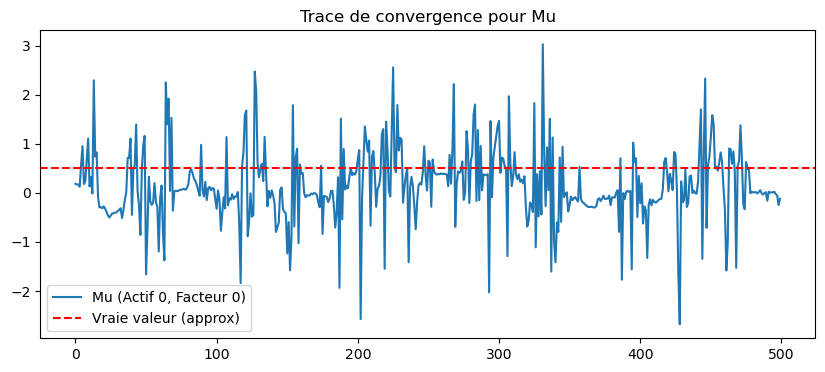

In [23]:
# 1. Paramètres
T_sim = 1000
n_sim = 10  # 10 actifs
p_sim = 2   # 2 facteurs
N_ITER = 500 # Nombre d'itérations MCMC

# 2. Données
data = simulate_data(T_sim, n_sim, p_sim)

# 3. Instanciation du Sampler
sampler = FactorCopulaSampler(data, p_sim)

# 4. Préparation du stockage (Trace)
# On stocke l'historique de mu pour visualiser la convergence par exemple
# Vous pouvez faire de même pour phi et sigma
trace_mu = np.zeros((N_ITER, n_sim, p_sim))

# 5. Boucle Principale
print("Démarrage du Gibbs Sampler...")
for it in tqdm(range(N_ITER)):
    
    # A. Mises à jour séquentielles
    # On appelle explicitement chaque étape dans l'ordre
    sampler.update_z()          # Step 4
    sampler.update_lambda_pg()  # Step 5
    sampler.update_sigma()      # Step 6
    sampler.update_mu_phi()     # Step 7
    
    # B. Stockage
    # On sauvegarde une copie profonde des paramètres à chaque itération
    trace_mu[it] = sampler.theta['mu'].copy()

print("Terminé !")

# 6. Visualisation rapide
plt.figure(figsize=(10, 4))
plt.plot(trace_mu[:, 0, 0], label="Mu (Actif 0, Facteur 0)")
plt.axhline(0.5, color='r', linestyle='--', label="Vraie valeur (approx)")
plt.title("Trace de convergence pour Mu")
plt.legend()
plt.show()

In [27]:
trace_mu[0]

array([[ 0.18359478, -0.00334005],
       [-0.48081909, -0.12859208],
       [ 0.5351051 ,  0.37044781],
       [ 0.03949999,  0.73679641],
       [ 0.31094227,  0.45816054],
       [-0.07199757,  0.85296275],
       [-0.12644326, -0.23417874],
       [ 1.69624451,  0.74529871],
       [ 0.96997264,  0.00633649],
       [ 0.43960141,  0.68123167]])